# Focusing on the North Celestial Pole Loop

Now that I have looked at the SPIDER on its own, it is time to look at the bigger picture. The SPIDER is not just on its own in the sky, it apart of the North Celestial Pole Loop (NCPL) which also connects Ursa Major and Polaris. It is important to look at the NCPL because it can help us find more evidence that a phase transition occured.

________________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all python libraries I will be using

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA, fit_spec
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the cube data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

I am also installing ROHSApy.

In [3]:
#!pip install ROHSApy

## Load the data cube

inpainted cube (new cube)

In [4]:
fitsname = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[:,:,:][0]
cube.shape

(654, 495, 603)

In [5]:
y_corner = 410-256 ; x_corner = 295 #y_corner_top, x_corner_left
subcube = cube[:, y_corner:y_corner+256, x_corner:x_corner+256]

In [6]:
hdr["NAXIS1"] = 256
hdr["NAXIS2"] = 256
hdr["CRPIX1"] -= 295
hdr["CRPIX2"] -= 154

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [7]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

Need to adjust the header for the axis to have correct units. I can define where I want my cuts in velocity and/or in the x and y axes, then subtract from the original header.

In [8]:
idx_lim_left = 200; idx_lim_right = 400

In [9]:
hdr["NAXIS3"] = 200 # The range of subvel (end_subvel - start_subvel)
hdr["CRPIX3"] -= idx_lim_left # This is to fix the position of the peaks to have the right index and velocity

In [10]:
index_arr = np.arange(cube[0].shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

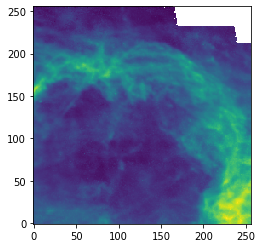

In [11]:
plt.imshow(np.sum(subcube, 0), origin='lower')

## Function for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [12]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [13]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-((x-cent)/(2*sigma))**2)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        c = params[i+1]
        s = params[i+2]
        y = y + a * np.exp( -((x - c)/(2*s))**2)
    return y

## Define the limits and the region

In [14]:
subvel = vel[:idx_lim_right-idx_lim_left]
subcube = subcube[idx_lim_left:idx_lim_right,:,:]

I can first just plot a random spectrum, then also plot the average spectrum, which will give us more information

In [15]:
# x_rand = 70; y_rand = 110 #interesting point 
# x_rand = 113; y_rand = 145 #interesting point 
# x_rand = 154; y_rand = 23 #interesting point 

x = 24  y = 24


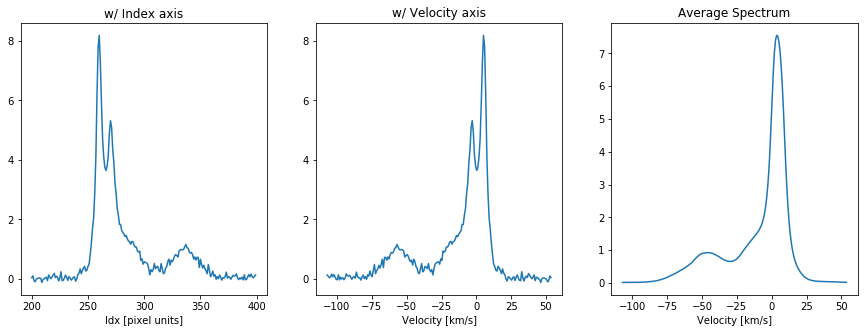

In [16]:
x_rand = random.randint(0,255) ; y_rand = random.randint(0,255)
print('x =',x_rand,' y =',y_rand)

avg = np.nanmean(subcube, (1,2))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("w/ Index axis"); plt.xlabel("Idx [pixel units]")
plt.plot(index_arr[idx_lim_left:idx_lim_right], subcube[:,y_rand, x_rand])

plt.subplot(1,3,2)
plt.title("w/ Velocity axis"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, subcube[:,y_rand, x_rand])

plt.subplot(1,3,3)
plt.title("Average Spectrum"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, avg)

plt.show()

## Noise Map

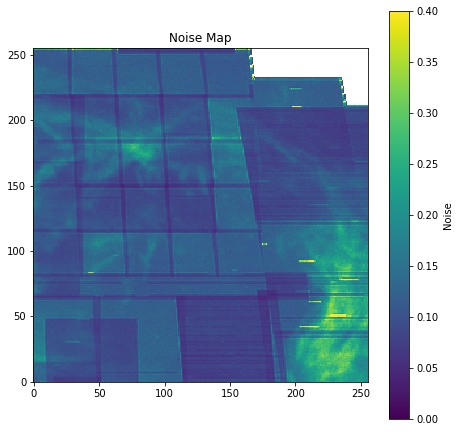

In [17]:
fig=plt.figure(figsize=(7.5,7.5))
#noise_cube = cube[:24] # Using the first 24 channels of the index axis.
#noise = np.std(noise_cube, 0)

noise = hdu[2].data[:,:][y_corner:y_corner+256, x_corner:x_corner+256]

rms = np.array([noise*(1+channel/20) for channel in subcube]) # channel means T_b
plt.title("Noise Map")
plt.imshow(rms[37+25], origin='lower', vmin=0, vmax=0.4) ; plt.colorbar(label='Noise')
#fig.savefig("Noise_map.png", bbox_inches='tight')

## Getting ROHSA to analyze a region

In [18]:
#!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
#import os
#os.chdir('ROHSA/src')
#!make
#os.chdir('../../')

## Define the ROHSA parameters

In [19]:
# Ranges:
subcube = subcube[:105] #[30:90]
subvel = subvel[:105] #[30:90]
rms = rms[:105] #[30:90]

subcube[subcube != subcube] = 0
#rms[rms != rms] = 0

In [20]:
fitsname_LVC = "LVC_cube_boot_100_100.fits"
hdu_LVC = fits.open(fitsname_LVC)
hdr_LVC = hdu_LVC[0].header
LVC_cube = hdu_LVC[0].data[:,:,:]
#core = ROHSA(LVC_cube_boot, hdr=hdr)
print(LVC_cube.shape)
LVC_cube[LVC_cube != LVC_cube] = 0

(105, 256, 256)


In [21]:
# Ranges:
subcube = subcube[:105] #[30:90]
subvel = subvel[:105] #[30:90]
rms = rms[:105] #[30:90]

subcube[subcube != subcube] = 0
#rms[rms != rms] = 0

path = "/mnt/raid-project/hp/mtaank/repos/Mukesh_SURP/NCPL/"

hdu0 = fits.PrimaryHDU(LVC_cube, header=hdr)
hdulist0 = fits.HDUList([hdu0])
hdulist0.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_100_100.fits", overwrite=True)

hdu1 = fits.PrimaryHDU(rms, header=hdr)
hdulist1 = fits.HDUList([hdu1])
hdulist1.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_rms_100_100.fits", overwrite=True)

(105, 256, 256)

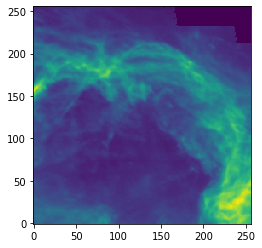

In [22]:
fitsname_test = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_100_100.fits"
hdu_test = fits.open(fitsname_test)
hdr_test = hdu_test[0].header
test = hdu_test[0].data[:,:,:]
plt.imshow(np.sum(test, 0), origin='lower')
test.shape

Now to set up the parameters for the Gaussian decomposition.

In [23]:
filename = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_100_100.fits" #@param
fileout = "!GHIGLS_NCPL_Tb_gauss_run_Noise3D_100_100_LVC_cube_boot_6G_norm_var=true_with_100_500.fits" #@param
filename_parameters = "parameters_NCPL_Noise3D_100_100_LVC_cube_boot_6G_norm_var=true_with_100_500.txt"
filename_noise = 'GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_rms_100_100.fits'
#filename_init_spec = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_inits_11G_TEST_3FITS_using_ROHSA_init_TEST.dat"
n_gauss = 6        #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 500  #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".true."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 
lb_sig_init = 1.0
ub_sig_init = 10.
lb_sig = 1.0
ub_sig = 12.0
init_spec = '.false.'
norm_var = '.true.'

core = ROHSA(LVC_cube, hdr=hdr_LVC)  
#core_rms = ROHSA(rms)
#core.array2dat(init_array_core, filename=filename_init_spec)
###core.cube2dat(filename=filename)
###core_rms.cube2dat(filename=filename_noise)
core.gen_parameters_3D(filename=filename, 
                    fileout=fileout,
                    filename_noise=filename_noise,
                    filename_parameters=filename_parameters,
                    #filename_init_spec=filename_init_spec,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    noise=noise,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    iprint_init=iprint_init,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig = lb_sig,
                    ub_sig = ub_sig,
                    #init_spec=init_spec,
                    save_grid=save_grid,
                    norm_var=norm_var)

Generate parameters_NCPL_Noise3D_100_100_LVC_cube_boot_6G_norm_var=true_with_100_500.txt file


In [24]:
#! ./ROHSA/src/ROHSA-3D parameters_NCPL_Noise3D_11G_no_init_ROHSA-3FITS.txt

## Obtain the Gaussian parameters for the decomposition

In [25]:
#!export PATH=$PATH:/home/amarchal/ROHSA-3FITS/src

In [26]:
#! ROHSA-3FITS paSrameters_NCPL_Noise3D_TEST_norm_var_LVC_cube_7G_norm_var=false.txt

In [27]:
n_gauss=7

In [28]:
fitsname_gaussian = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_boot_7G_norm_var=true_100_100_NEW.fits"
hdu_gaussian = fits.open(fitsname_gaussian)
hdr_gaussian = hdu_gaussian[0].header
gaussian = hdu_gaussian[0].data[:,:,:]
print(gaussian.shape)

model = core.return_result_cube(gaussian=gaussian)
print(model.shape)

amplitude = gaussian[0::3]
position = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian[1::3]))
dispersion = gaussian[2::3] * dv

amplitude_pix = gaussian[0::3]
position_pix = gaussian[1::3]
dispersion_pix = gaussian[2::3]

integral = amplitude * dispersion * np.sqrt(2*np.pi) 
NHI_map = integral * C

(21, 256, 256)
(105, 256, 256)


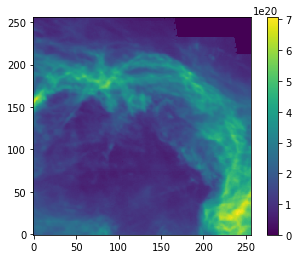

In [29]:
plt.imshow(np.sum(model, 0)*C*dv, origin='lower') ; plt.colorbar()

## Plot a Spectrum

Now, I want to plot a random spectrum / pixel in this region

In [30]:
def plot_spect(x_pos, y_pos, vel, model, cube, gaussian, model2="None", caption=""):
    fig = plt.figure()
    plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13)
    plt.ylabel("T$_{b}$ [K]", fontsize=13)
    plt.plot(vel, cube, color='darkorchid', label="x="+str(x_pos)+", y="+str(y_pos))#,  label="data")
    plt.plot(vel, model , 'black')#, label="model (pix by pix)")
    if model2 != "None":
        plt.plot(vel, model2 , 'g')#, label="model (comp by comp)")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(vel)), gaussian[0::3][i][y_pos,x_pos], gaussian[1::3][i][y_pos,x_pos], gaussian[2::3][i][y_pos,x_pos])
        if gaussian[2::3][i][y_pos,x_pos] < 2.5:
            plt.plot(vel, gauss, color='red')#, label="CNM")
        if gaussian[2::3][i][y_pos,x_pos] >=2.5 and gaussian[2::3][i][y_pos,x_pos] < 4.5:
            plt.plot(vel, gauss, color='green')#, label="UNM")
        if gaussian[2::3][i][y_pos,x_pos] >= 4.5:
            plt.plot(vel, gauss, color='blue')#, label="WNM")
    
    plt.legend()
    #plt.show()
    fig.savefig(caption, bbox_inches="tight")

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper right')

def plot_spect_color(x, y, v, model, cube, gaussian, caption=""):
    #fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel("v [$km$ $s^{-1}$]")
    ax.set_ylabel("T$_{b}$ [$K$]")
    ax.plot(v, cube, color='green',  label="data")
    ax.plot(v, model , color='black', label="model")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(v)), gaussian[0::3][i][y,x], gaussian[1::3][i][y,x], gaussian[2::3][i][y,x])
        if gaussian[2::3][i][y,x] < 2.0:
            ax.plot(v, gauss, color='deepskyblue', label="CNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >=2.0 and gaussian[2::3][i][y,x] < 4.5:
            ax.plot(v, gauss, color='darkorchid', label="UNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >= 4.5:
            ax.plot(v, gauss, color='red', label="WNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____, alpha=0.2)
            
    #legend_without_duplicate_labels(ax)
    fig.savefig(caption, bbox_inches="tight")

x =  135
y =  6


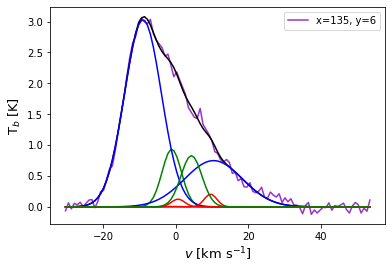

The column density for each Gaussian: 
 [4.74942895e+16 1.04729094e+18 1.62988168e+18 1.09399219e+19
 1.13624312e+19 2.71508915e+19 7.02344894e+19] 

The fractional column density for each Gaussian: 
 [3.8798596e-04 8.5554319e-03 1.3314678e-02 8.9369394e-02 9.2820920e-02
 2.2179855e-01 5.7375312e-01]


In [31]:
x_pos = random.randint(0,255) ; 
y_pos = random.randint(0,255)
print("x = ", x_pos) ; print("y = ", y_pos)

plot_spect(x_pos, y_pos, subvel, model[:, y_pos, x_pos], LVC_cube[:, y_pos, x_pos], gaussian, model2="None", caption="random_spec.png")
plt.show()
#plot_spect_color(x_pos, y_pos, subvel, model[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian)
#plt.show()

#Now can look at these Gaussians to see if they are significant by looking at the integral

integral_spectrum = (amplitude[:,y_pos,x_pos] * dispersion[:,y_pos,x_pos] * np.sqrt(2*np.pi) * C)
sum_of_integral = np.sum(integral_spectrum)
frac_integral = integral_spectrum / sum_of_integral
print("The column density for each Gaussian: \n",np.sort(integral_spectrum), '\n')
print("The fractional column density for each Gaussian: \n",np.sort(frac_integral))

# Good one: x=26, y=8

## Find the value of $\chi^{2}$

### Map of Degrees of Freedom

In [32]:
free_params_map = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map = np.zeros((subcube.shape[2],subcube.shape[1]))
free_params_map_LVC = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_LVC = np.zeros((subcube.shape[2],subcube.shape[1]))
free_params_map_BVC = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_BVC = np.zeros((subcube.shape[2],subcube.shape[1]))
lim_for_signif_gauss = 1.e-2

for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum = (amplitude[:,j,i] * dispersion[:,j,i] * np.sqrt(2*np.pi) * C)
        sum_integ_spec = np.sum(integral_spectrum)
        frac_integral = integral_spectrum / sum_integ_spec
        
        num_good_gauss_LVC = 0
        for k in range(n_gauss):
            #LVC
            if position[k][j][i] > -7:
                if frac_integral[k] > lim_for_signif_gauss:
                    num_good_gauss_LVC = num_good_gauss_LVC + 1
                
        signif_gauss_map_LVC[j][i] = num_good_gauss_LVC
        free_params_map_LVC[j][i] = (75) - 3*num_good_gauss_LVC
        
        
        num_good_gauss_BVC = 0
        for k in range(n_gauss):
            #BVC
            if position[k][j][i] <= -7:
                if frac_integral[k] > lim_for_signif_gauss:
                    num_good_gauss_BVC = num_good_gauss_BVC + 1
                
        signif_gauss_map_BVC[j][i] = num_good_gauss_BVC
        free_params_map_BVC[j][i] = (105-75) - 3*num_good_gauss_BVC
        
for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum = (amplitude[:,j,i] * dispersion[:,j,i] * np.sqrt(2*np.pi) * C)
        sum_integ_spec = np.sum(integral_spectrum)
        frac_integral = integral_spectrum / sum_integ_spec
        
        num_good_gauss = 0
        for k in range(n_gauss):
            
            if frac_integral[k] > lim_for_signif_gauss:
                num_good_gauss = num_good_gauss + 1
                
        signif_gauss_map[j][i] = num_good_gauss
        free_params_map[j][i] = (subcube.shape[0]) - 3*num_good_gauss        

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


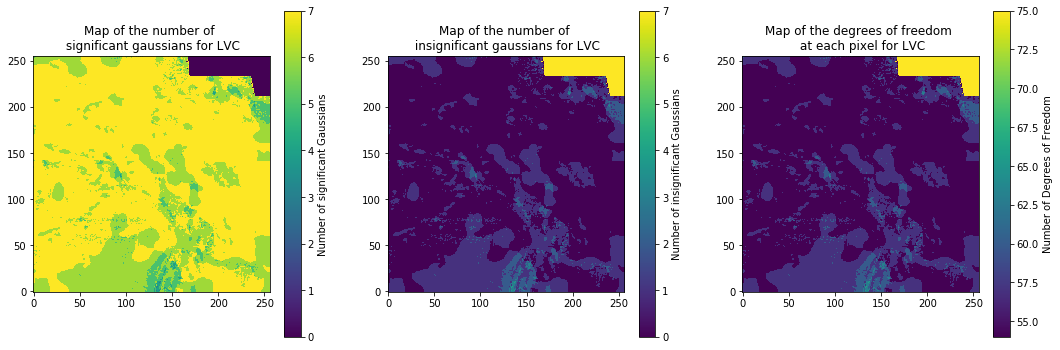

In [33]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians for LVC")
plt.imshow(signif_gauss_map_LVC, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians for LVC")
plt.imshow(n_gauss - signif_gauss_map_LVC, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel for LVC")
plt.imshow(free_params_map_LVC, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

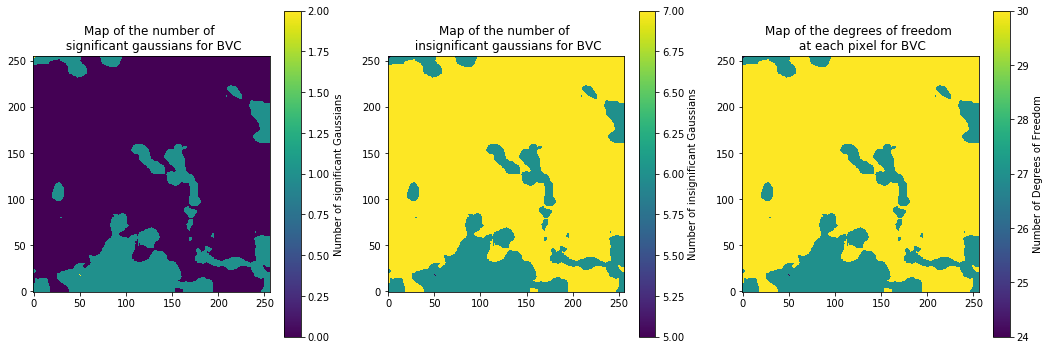

In [34]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians for BVC")
plt.imshow(signif_gauss_map_BVC, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians for BVC")
plt.imshow(n_gauss - signif_gauss_map_BVC, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel for BVC")
plt.imshow(free_params_map_BVC, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

mean of significant gaussians =  6.6002349853515625
mean of insignificant gaussians =  0.3997650146484375


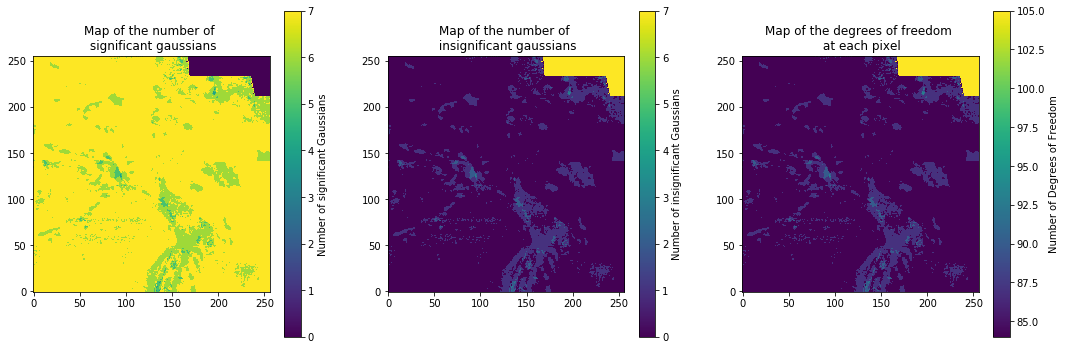

In [35]:
# Can plot a map of the number of free parameters at each pixel
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians")
plt.imshow(signif_gauss_map, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians")
plt.imshow(n_gauss - signif_gauss_map, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel")
plt.imshow(free_params_map, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

print("mean of significant gaussians = ", np.mean(signif_gauss_map))
print("mean of insignificant gaussians = ", np.mean(n_gauss - signif_gauss_map))
#fig.savefig("Map_of_Degrees_of_Freedom_and_Significant_Gauss.png", bbox_inches='tight')

### Map of $\chi^{2}$

In [36]:
diff = (model[:105] - LVC_cube[:105])

chi_sq_map = np.sum((diff/rms[:105])**2, 0)

#chi_sq_map[chi_sq_map != chi_sq_map] = 0
red_chi_sq_map = chi_sq_map / free_params_map
#red_chi_sq_map[red_chi_sq_map != red_chi_sq_map] = 0

In [37]:
diff_LVC = (model[:75] -LVC_cube[:75])

chi_sq_map_LVC = np.sum((diff_LVC / rms[:75])**2, 0)

#chi_sq_map_LVC[chi_sq_map != chi_sq_map_LVC] = 0
red_chi_sq_map_LVC = chi_sq_map_LVC / free_params_map_LVC
#red_chi_sq_map_LVC[red_chi_sq_map_LVC != red_chi_sq_map_LVC] = 0

In [38]:
diff_BVC = (model[75:] - LVC_cube[75:])

chi_sq_map_BVC = np.sum((diff_BVC / rms[75:])**2, 0)
#chi_sq_map_BVC[chi_sq_map != chi_sq_map_BVC] = 0
red_chi_sq_map_BVC = chi_sq_map_BVC / free_params_map_BVC
#red_chi_sq_map_BVC[red_chi_sq_map_BVC != red_chi_sq_map_BVC] = 0

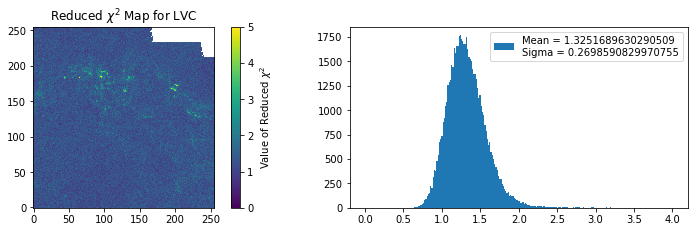

In [39]:
fig=plt.figure(figsize=(20/1.5,5/1.5))
plt.subplot(1,2,1)
plt.title("Reduced $\chi^{2}$ Map for LVC")
plt.imshow(red_chi_sq_map_LVC, origin='lower', vmin=0, vmax=5.) ; plt.colorbar(label="Value of Reduced $\chi^{2}$")
plt.subplot(1,2,2)
y_red_chisq_map_LVC, x_red_chisq_map_LVC, _red_chisq_map_LVC = plt.hist(red_chi_sq_map_LVC.ravel(), bins=250, range=[1e-20,4.], label="Mean = "+str(np.nanmean(red_chi_sq_map_LVC))+"\nSigma = "+str(np.sqrt(np.nanvar(red_chi_sq_map_LVC))))
plt.legend()
#fig.savefig("rchi_sq_LVC_8G.png", bbox_inches='tight')

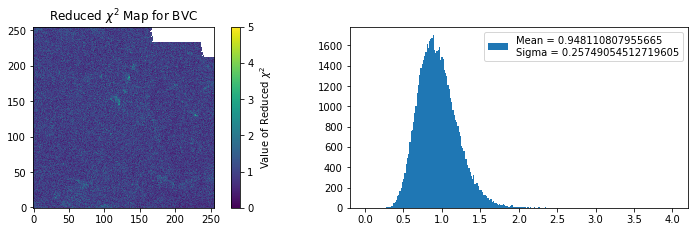

In [40]:
fig=plt.figure(figsize=(20/1.5,5/1.5))
plt.subplot(1,2,1)
plt.title("Reduced $\chi^{2}$ Map for BVC")
plt.imshow(red_chi_sq_map_BVC, origin='lower', vmin=0, vmax=5.) ; plt.colorbar(label="Value of Reduced $\chi^{2}$")
plt.subplot(1,2,2)
y_red_chisq_map_BVC, x_red_chisq_map_BVC, _red_chisq_map_BVC = plt.hist(red_chi_sq_map_BVC.ravel(), bins=250, range=[1e-20,4.], label="Mean = "+str(np.nanmean(red_chi_sq_map_BVC))+"\nSigma = "+str(np.sqrt(np.nanvar(red_chi_sq_map_BVC))))
plt.legend()
#fig.savefig("rchi_sq_BVC_8G.png", bbox_inches='tight')

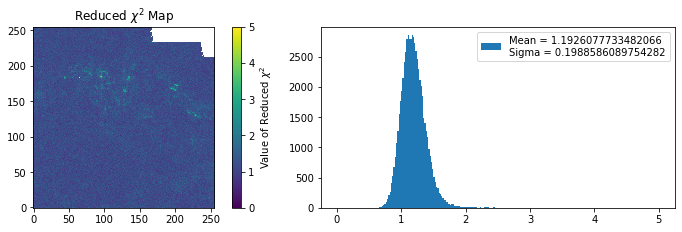

In [41]:
fig = plt.figure(figsize=(20/1.5,5/1.5))
#plt.subplot(2,2,1)
#plt.title("$\chi^{2}$ Map")
#plt.imshow(chi_sq_map, origin='lower', vmin=0, vmax=500.) ; plt.colorbar(label="Value of $\chi^{2}$")
#plt.subplot(2,2,2)
#y_chisq_map, x_chisq_map, _chisq_map = plt.hist(chi_sq_map.ravel(), bins=250, range=[1e-20,300.], label="Mean = "+str(np.nanmean(chi_sq_map))+"\nSigma = "+str(np.sqrt(np.var(chi_sq_map))))
#plt.legend()
plt.subplot(1,2,1)
plt.title("Reduced $\chi^{2}$ Map")
plt.imshow(red_chi_sq_map, origin='lower', vmin=0, vmax=5) ; plt.colorbar(label="Value of Reduced $\chi^{2}$")
plt.subplot(1,2,2)
y_red_chisq_map, x_red_chisq_map, _red_chisq_map = plt.hist(red_chi_sq_map.ravel(), bins=250, range=[1e-20,5.], label="Mean = "+str(np.nanmean(red_chi_sq_map))+"\nSigma = "+str(np.sqrt(np.nanvar(red_chi_sq_map))))
plt.legend()
plt.subplots_adjust(wspace=0.1, hspace=0.3)
#fig.savefig("rchi_sq_full_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')#

The following pixel spectrum represents the one with the worst chi squared value.

In [42]:
y_pos, x_pos = np.unravel_index(chi_sq_map.argmax(), chi_sq_map.shape)
print("x = ", x_pos) ; print("y = ", y_pos)
print("value of chi squared for this spectrum: ",chi_sq_map[y_pos][x_pos])

plot_spect_color(x_pos, y_pos, subvel, model[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian)

x =  240
y =  212
value of chi squared for this spectrum:  nan


This was actually determined to be a problem due to RFI (Radio Frequency Interference) when the data recording was done.

In [43]:
#sub_hdr = hdr
#sub_hdr["CRPIX1"] -= 285
#sub_hdr["CRPIX2"] -= 154

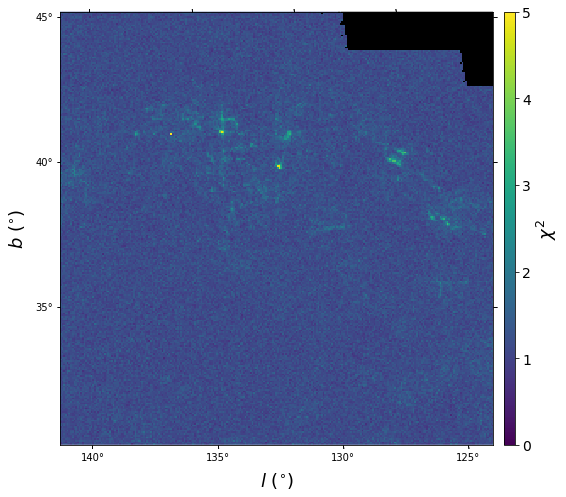

In [44]:
red_chi_sq_map[red_chi_sq_map == 0.] = np.nan
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='darkgrey')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)
import marchalib as ml
w = ml.wcs2D(hdr)
fig = plt.figure(figsize=(10.5/1.33, 10/1.33))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"$l\ (^{\circ})$", fontsize=18.)
ax.set_ylabel(r"$b\ (^{\circ})$", fontsize=18.)
img = ax.imshow(red_chi_sq_map, vmin=0,vmax=5, **imkw_viridis)
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$\chi^{2}$", fontsize=18.)
#plt.savefig('chi_2_map_LVC_cube_injected_noise_11G_with_5G.png', format='png', bbox_inches='tight', pad_inches=0.02)

### Map of $\chi^{2}$ Contribution

In [45]:
chi_sq_contrib = (diff / rms[:105])**2
#chi_sq_contrib[chi_sq_contrib != chi_sq_contrib] = 0

channel = 74


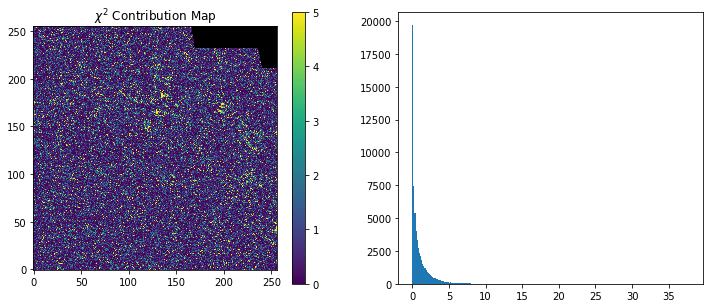

In [46]:
channel = np.random.randint(0,75)
print("channel =", channel)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("$\chi^{2}$ Contribution Map")
plt.imshow(chi_sq_contrib[channel], origin='lower', vmin=0, vmax=5.) ; plt.colorbar()
plt.subplot(1,2,2)
y_chisq_contrib, x_chisq_contrib, _chisq_contrib = plt.hist(chi_sq_contrib[channel].ravel(), bins=250)
plt.show()

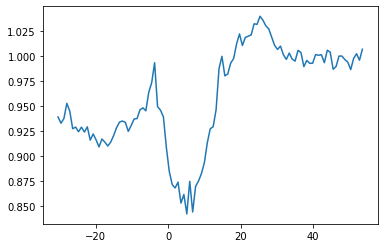

In [47]:
chi_sq_contrib = (diff / rms)**2

fig=plt.figure()
plt.plot(subvel, np.nanmean(chi_sq_contrib, (1,2)))
#fig.savefig("chi_sq_contrib_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

## Plot a mosaic of spectra

x =  209
y =  190


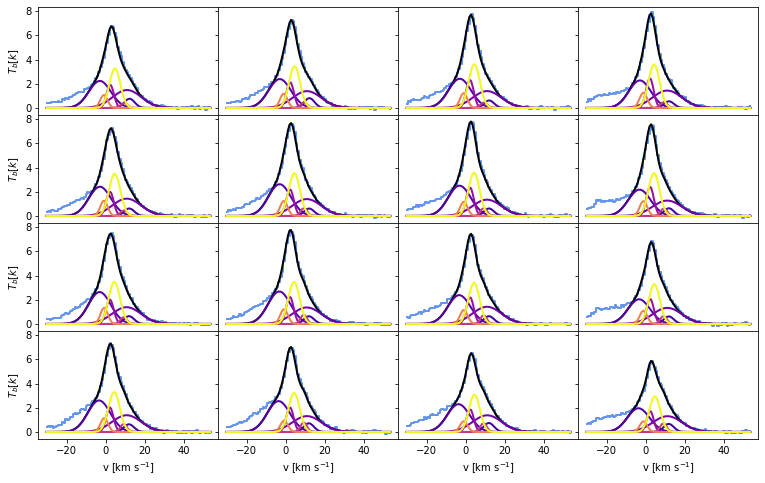

In [48]:
## Mosaic of the Spectra
x_pos = np.random.randint(0,255) ; print("x = ", x_pos)
y_pos = np.random.randint(0,255) ; print("y = ", y_pos)

pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

ny = 4; nx = 4
center_y = y_pos; center_x = x_pos
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(subvel, subcube[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(subvel, model[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(n_gauss):
            axs[i][j].plot(subvel, core.gauss(np.arange(len(subvel)), gaussian[0::3][k][center_y+i,center_x+j],
                                              gaussian[1::3][k][center_y+i,center_x+j], gaussian[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=plt.cm.plasma(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'$T_{b}[k]$')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
#fig.savefig("Mosaic_of_Spectra.png", bbox_inches='tight')

<Figure size 1440x720 with 0 Axes>

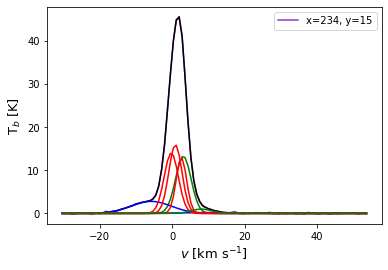

In [49]:
plt.figure(figsize=(20,10))
x_pos = random.randint(0,255) ; y_pos = random.randint(0,255)
plot_spect(x_pos, y_pos, subvel, model[:, y_pos, x_pos], LVC_cube[:, y_pos, x_pos], gaussian, model2="None", caption="random_spec.png")
plt.show()
# x=27, y=194

# 2D Histogram: Sigma-Mu

In [50]:
iddx = np.argsort(np.mean(position, axis=(1,2)))
field = np.array([NHI_map[idd] for idd in iddx])
vfield = np.array([position[idd] for idd in iddx])
pixfield = np.array([position_pix[idd] for idd in iddx])
ampfield = np.array([amplitude[idd] for idd in iddx])
sigfield = np.array([dispersion[idd] for idd in iddx])

In [51]:
LVC_IVC1_bound_CNM_UNM = -7.
LVC_IVC1_bound_WNM = LVC_IVC1_bound_CNM_UNM
IVC1_IVC2_bound = -30.
CNM_UNM_LVC_bound = 2.2
CNM_UNM_IVC1_2_bound = CNM_UNM_LVC_bound
UNM_WNM_bound = 4.75
CNM_UNM_bound = CNM_UNM_LVC_bound 

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10



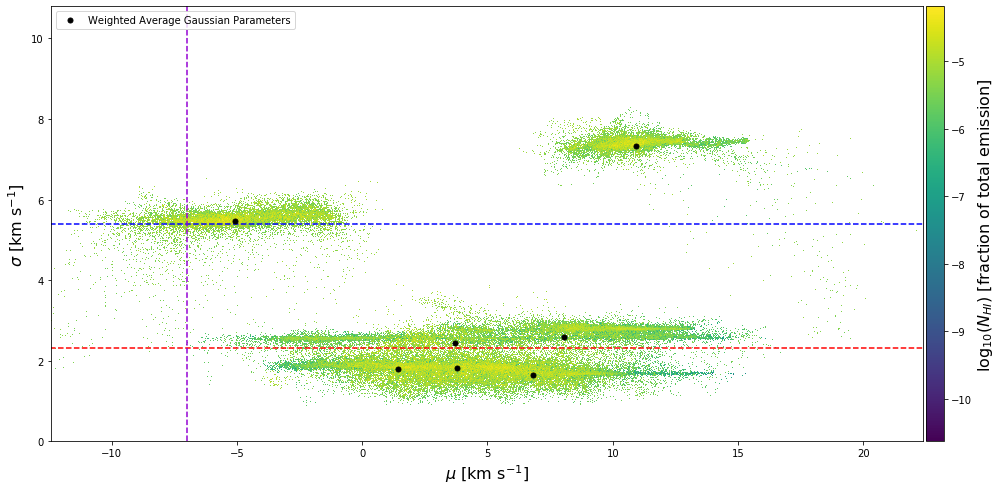

In [52]:
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

#foo = init_array
#for i in range(len(foo)):
#    amp = foo[::3]
#    pos = np.array(spec_2_velocity(crval3,cdelt3,crpix3,foo[1::3]))
#    dis = foo[2::3]*dv
    
x_bins = np.linspace(np.min(vfield.ravel()), np.max(vfield.ravel()), 1200)
y_bins = np.linspace(0.1,np.max(sigfield)+1, 1200)
H, xedges, yedges = np.histogram2d(vfield.ravel(), sigfield.ravel(),
                                   weights=np.sqrt(2.*np.pi)*ampfield.ravel()*(sigfield.ravel())*C/np.sum(field),
                                   bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))

#Weighted Averages of the Clusters:
weighted_vel = [np.sum(vfield[i]*field[i])/np.sum(field[i]) for i in range(n_gauss)]
weighted_sig = [np.sum(sigfield[i]*field[i])/np.sum(field[i]) for i in range(n_gauss)]

#plt.plot(subvel, np.nanmean(subcube, (1,2)), color="black")
#plt.plot(pos, dis, color='darkorange', linestyle='None', marker='.', markersize=10, label="ROHSA_init Optimal Params")
#plt.plot(np.mean(vfield, (1,2)).ravel(), np.mean(sigfield, (1,2)).ravel(), color='black', linestyle='None', marker='.', markersize=10, label="Average Gaussian Params")
#plt.plot(np.array(spec_2_velocity(crval3,cdelt3,crpix3,init_array_core[1::3])).ravel(), np.array(init_array_core[2::3]).ravel(), color="darkgoldenrod", linestyle='None', marker='^', markersize=7, label="ROHSA_init Parameters")
plt.plot(np.array(weighted_vel).ravel(), np.array(weighted_sig).ravel(), color='black', linestyle='None', marker='o', markersize=5, label="Weighted Average Gaussian Parameters")
plt.axvline(x=LVC_IVC1_bound_CNM_UNM, ymin=0., color='darkviolet', linestyle='--'),# label="LVC-IVC1 Boundary")
plt.axvline(x=IVC1_IVC2_bound, color='violet', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.axvline(x=-90, color='black', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.axvline(x=25, color='black', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.hlines(y=5.4,xmin=-120, xmax=80, color='blue', linestyle='--')#, label="UNM-WNM Boundary")
plt.hlines(y=2.3,xmin=-120, xmax=80, color='red', linestyle="--")
plt.plot()
plt.legend(loc="upper left")

ax = fig.add_subplot(111)
ax.set_ylim([0., np.max(sigfield)+2.5])
ax.set_xlim([np.min(vfield.ravel()),np.max(vfield.ravel())])
ax.set_xlabel(r'$\mu$ [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="viridis")
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$) [fraction of total emission]', fontsize = 16)

#fig.savefig("sigma_v_diagram_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches="tight")

In [53]:
#fig = plt.figure(figsize=(20,5))
#plt.subplot(1,3,1)# ; plt.title("CNM Mass Fraction", fontsize=15)
#plt.imshow(field[0], origin='lower', cmap="inferno") ; plt.colorbar()
#plt.subplot(1,3,2)# ; plt.title("LNM Mass Fraction", fontsize=15)
#plt.imshow(field[1], origin='lower', cmap="inferno") ; plt.colorbar()
#plt.subplot(1,3,3)# ; plt.title("WNM Mass Fraction", fontsize=15)
#plt.imshow(field[2], origin='lower', cmap="inferno") ; plt.colorbar()
#plt.subplots_adjust(wspace=0.)
#fig.savefig("Column_Density_Maps_WNM_cube_from_10G_SMART_soln_with_3G.png", bbox_inches='tight')

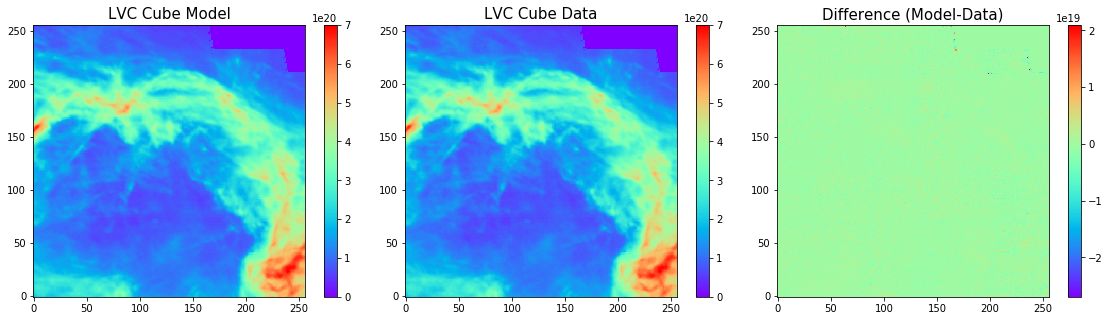

In [54]:
fig = plt.figure(figsize=(20,5))
sum_model = np.sum(model, 0)
sum_LVCcube = np.sum(LVC_cube, 0)
plt.subplot(1,3,1) ; plt.title("LVC Cube Model", fontsize=15)
plt.imshow(sum_model*C*dv, origin='lower', cmap='rainbow', vmax=7e20) ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LVC Cube Data", fontsize=15)
plt.imshow(sum_LVCcube*C*dv, origin='lower', cmap='rainbow', vmax=7e20) ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("Difference (Model-Data)", fontsize=15)
plt.imshow((sum_model-sum_LVCcube)*C*dv, origin='lower', cmap='rainbow') ; plt.colorbar()
plt.subplots_adjust(wspace=0.)
#fig.savefig("Total_Map_compare_model&data_10G_SMART.png", bbox_inches='tight')

In [55]:
LVC_CNM = np.zeros((256,256)) ; BVC_CNM = np.zeros((256,256)) ; IVC_CNM = np.zeros((256,256))
LVC_LNM = np.zeros((256,256)) ; BVC_LNM = np.zeros((256,256)) ; IVC_LNM = np.zeros((256,256))
LVC_WNM = np.zeros((256,256)) ; BVC_WNM = np.zeros((256,256)) ; IVC_WNM = np.zeros((256,256))

for k in range(n_gauss):
    if weighted_sig[k] <= CNM_UNM_bound:
        if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
            LVC_CNM = LVC_CNM + field[k]
    if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
        if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_CNM = BVC_CNM + field[k]
        if weighted_vel[k] < IVC1_IVC2_bound:
            IVC_CNM = IVC_CNM + field[k]
    if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
        if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
            LVC_LNM = LVC_LNM + field[k]
    if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
        if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_LNM = BVC_LNM + field[k]
        if weighted_vel[k] < IVC1_IVC2_bound:
            IVC_LN = IVC_LNM + field[k]
    if weighted_sig[k] > UNM_WNM_bound:
        if weighted_vel[k] >= LVC_IVC1_bound_WNM:
            LVC_WNM = LVC_WNM + field[k]
        if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_WNM = BVC_WNM + field[k]
        if weighted_vel[k] < IVC1_IVC2_bound:
            IVC_WNM = IVC_WNM + field[k]
            
total_LVC = LVC_CNM + LVC_LNM + LVC_WNM
total_BVC = BVC_CNM + BVC_LNM + BVC_WNM
total_IVC = IVC_CNM + IVC_LNM + IVC_WNM

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys



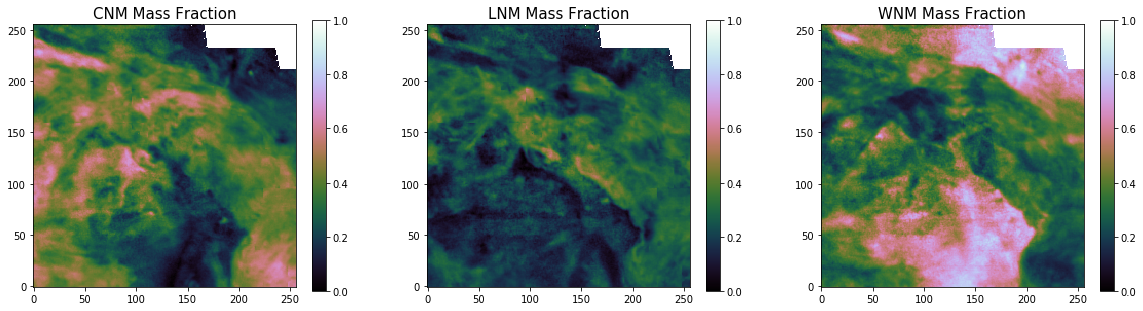

In [56]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1) ; plt.title("CNM Mass Fraction", fontsize=15)
plt.imshow(LVC_CNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LNM Mass Fraction", fontsize=15)
plt.imshow(LVC_LNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("WNM Mass Fraction", fontsize=15)
plt.imshow(LVC_WNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplots_adjust(wspace=0.2)
#fig.savefig("Mass_Fraction_Maps_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

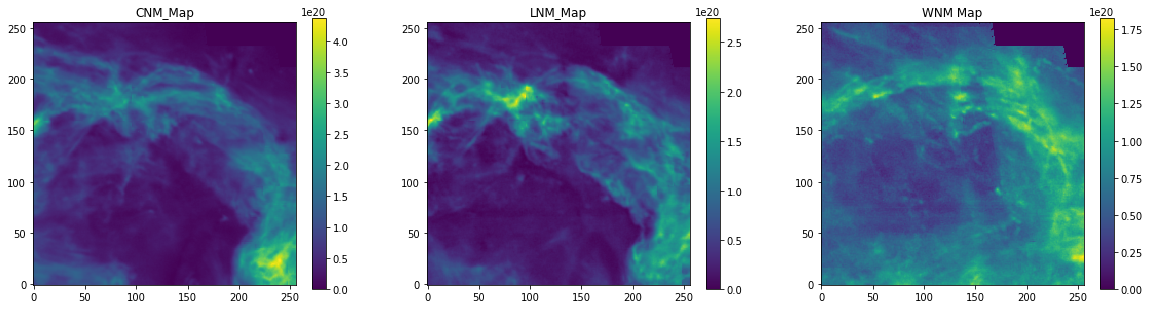

In [57]:
f=plt.figure(figsize=(20,5))
plt.subplot(1,3,3) ; plt.title("WNM Map")
plt.imshow(LVC_WNM, origin='lower') ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LNM_Map")
plt.imshow(LVC_LNM, origin='lower') ; plt.colorbar()
plt.subplot(1,3,1) ; plt.title("CNM_Map")
plt.imshow(LVC_CNM, origin='lower') ; plt.colorbar()
#f.savefig("Maps_of_CNM-and-WNM_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

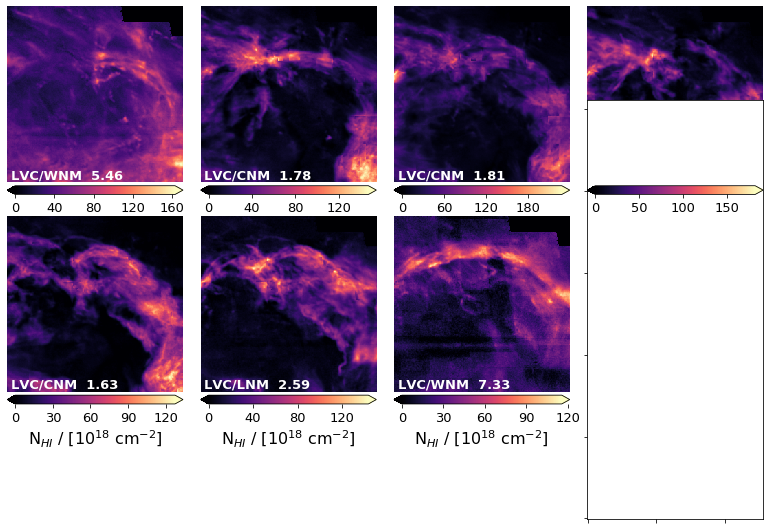

In [58]:
#Plot mosaic field   
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

lh = 2; lw = 4
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((40/1.5,35/1.5))))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.5, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="magma")
        color = "white"
        if weighted_sig[k] <= CNM_UNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")       
                       
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=13.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
        if k ==n_gauss:
            break
#axs[1][3].imshow(0*field[0]/10**18, origin="lower", cmap="inferno") 
        
#fig1.savefig("col_dens_mosaic_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

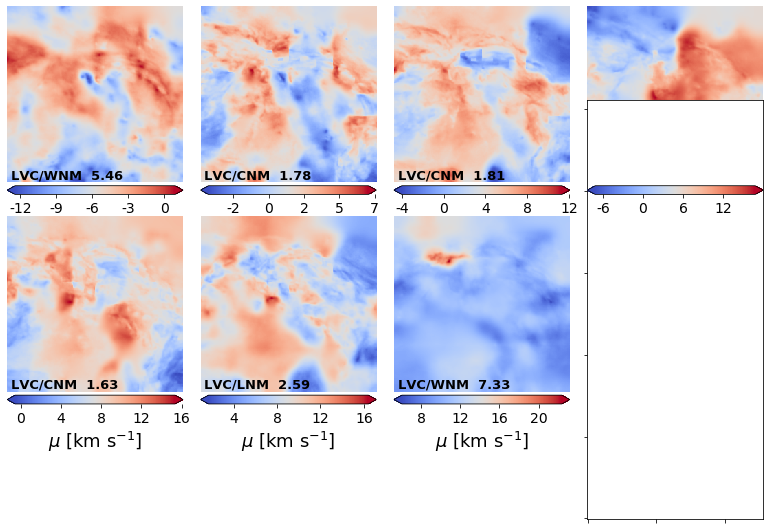

In [59]:
#Plot mosaic field mean
lh = 2; lw = 4
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((40/1.5,35/1.5))))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.5, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        color = "black"
        if weighted_sig[k] <= CNM_UNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")       
                   
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=18.)
        k += 1
        if k ==n_gauss:
            break
#axs[1][3].imshow(0*field[0]/10**18, origin="lower", cmap="inferno")  
#plt.savefig('mean_velocity_mosaic_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png', format='png', bbox_inches='tight', pad_inches=0.02)

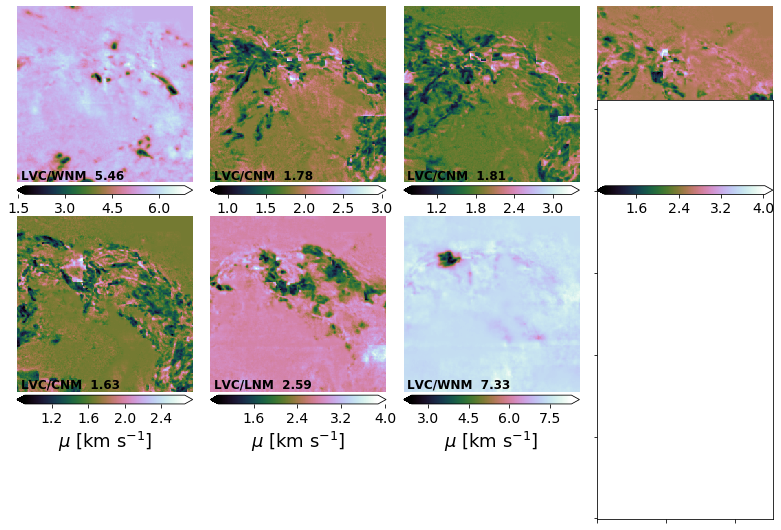

In [60]:
#Plot mosaic field sigma   
lh = 2; lw = 4
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((40/1.5,35/1.5))))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.5, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        color = "black"
        if weighted_sig[k] <= CNM_UNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] > UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")       
                   
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=18.)
        k += 1
        if k ==n_gauss:
            break
#axs[1][3].imshow(0*field[0]/10**18, origin="lower", cmap="inferno") 
#plt.savefig('mean_velocity_dispersion_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png', format='png', bbox_inches='tight', pad_inches=0.02)

## 50 Runs :

In [61]:
fitsname_LVC = "LVC_cube_boot_100_100.fits"
hdu_LVC = fits.open(fitsname_LVC)
hdr_LVC = hdu_LVC[0].header
LVC_cube_base = hdu_LVC[0].data[:,:,:]
#core = ROHSA(LVC_cube_boot, hdr=hdr)
print(LVC_cube_base.shape)
LVC_cube_base[LVC_cube_base != LVC_cube_base] = 0

(105, 256, 256)


In [62]:
from ROHSApy import fit_spec
vmin = [0]
vmax = [105] #length of velocity axis
mean_spec = np.mean(LVC_cube_base, (1,2))
core_init = fit_spec(Tb=mean_spec)
init_array_core = core_init.init_spectrum(np.full((3*n_gauss), 1.), n_gauss,mean_spec,lb_sig_init,ub_sig_init, \
                                     iprint_init, amp_fact_init, sig_init, maxiter_init, 1, vmin, vmax)
fit_core = core_init.model_spectrum(init_array_core, mean_spec, n_gauss)

In [63]:
init_array_core 

array([ 1.88003577, 58.73752384,  6.25384632,  1.47374857, 73.64749182,
        6.99395193,  0.49379795, 51.18563257,  9.49364555,  0.49008262,
       64.47066578,  1.89090941,  0.4172865 , 56.35341555,  2.23590563,
        4.40705332, 61.93794339,  4.74973119,  0.55890986, 58.42158738,
        3.91628014])

In [64]:
num_runs=50

model_multi_from_sigma_v = np.zeros((num_runs, 105, 256, 256))
gaussian_multi_from_sigma_v = np.zeros((num_runs, n_gauss*3, 256, 256))

amplitude_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
amplitude_pix_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
position_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
position_pix_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_pix_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))

field_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
vfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
pixfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
ampfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
sigfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))

integral_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
NHI_map_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))

In [65]:
for i in range(50):
    #fitsname_multi_from_sigma_v = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_sigma-v_nh_weighting_FIXED_"+str(i)+".fits"
    #fitsname_multi_from_sigma_v = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_sigma-v_nh_weighting_"+str(i)+".fits"
    fitsname_multi_from_sigma_v = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_sigma-v_step_iii_"+str(i)+".fits"
    hdu_multi_from_sigma_v = fits.open(fitsname_multi_from_sigma_v)
    hdr_multi_from_sigma_v = hdu_multi_from_sigma_v[0].header
    
    gaussian_multi_from_sigma_v[i] = hdu_multi_from_sigma_v[0].data[:,:,:]
    model_multi_from_sigma_v[i] = core.return_result_cube(gaussian=gaussian_multi_from_sigma_v[i])

    amplitude_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][0::3]
    position_multi_from_sigma_v[i] = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_multi_from_sigma_v[i][1::3]))
    dispersion_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][2::3] * dv

    amplitude_pix_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][0::3]
    position_pix_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][1::3]
    dispersion_pix_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][2::3]

    integral_multi_from_sigma_v[i] = amplitude_multi_from_sigma_v[i] * dispersion_multi_from_sigma_v[i] * np.sqrt(2*np.pi) 
    NHI_map_multi_from_sigma_v[i] = integral_multi_from_sigma_v[i] * C

    iddx_multi_from_sigma_v = np.argsort(np.mean(position_multi_from_sigma_v[i], axis=(1,2)))
    field_multi_from_sigma_v[i] = np.array([NHI_map_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    vfield_multi_from_sigma_v[i] = np.array([position_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    pixfield_multi_from_sigma_v[i] = np.array([position_pix_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    ampfield_multi_from_sigma_v[i] = np.array([amplitude_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    sigfield_multi_from_sigma_v[i] = np.array([dispersion_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])

In [66]:
num_runs=50

model_multi_rnd_boot_cube = np.zeros((num_runs, 105, 256, 256))
gaussian_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss*3, 256, 256))

amplitude_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
amplitude_pix_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
position_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
position_pix_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_pix_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))

field_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
vfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
pixfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
ampfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
sigfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))

integral_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
NHI_map_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))

In [67]:
LVC_cube = np.zeros((num_runs, 105, 256, 256))
for i in range(num_runs):
    fitsname_LVC = "LVC_cube_boot_100_100_"+str(i)+".fits"
    hdu_LVC = fits.open(fitsname_LVC)
    hdr_LVC = hdu_LVC[0].header
    LVC_cube[i] = hdu_LVC[0].data[:,:,:]
    LVC_cube[i][LVC_cube[i] != LVC_cube[i]] = 0
    LVC_cube[i] = LVC_cube[i][:105]
subvel = subvel[:105]
rms = rms[:105]

In [68]:
for i in range(num_runs):
    #fitsname = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_"+str(n_gauss)+"G_random_l_bfgs_opt_"+str(i+1)+".fits"
    fitsname_multi_rnd_boot_cube = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_bootcube_step_iii_"+str(i)+".fits"
    hdu_multi_rnd_boot_cube = fits.open(fitsname_multi_rnd_boot_cube)
    hdr_multi_rnd_boot_cube = hdu_multi_rnd_boot_cube[0].header

    gaussian_multi_rnd_boot_cube[i] = hdu_multi_rnd_boot_cube[0].data[:,:,:]
    model_multi_rnd_boot_cube[i] = core.return_result_cube(gaussian=gaussian_multi_rnd_boot_cube[i])

    amplitude_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][0::3]
    position_multi_rnd_boot_cube[i] = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_multi_rnd_boot_cube[i][1::3]))
    dispersion_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][2::3] * dv

    amplitude_pix_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][0::3]
    position_pix_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][1::3]
    dispersion_pix_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][2::3]

    integral_multi_rnd_boot_cube[i] = amplitude_multi_rnd_boot_cube[i] * dispersion_multi_rnd_boot_cube[i] * np.sqrt(2*np.pi) 
    NHI_map_multi_rnd_boot_cube[i] = integral_multi_rnd_boot_cube[i] * C

    iddx_multi_rnd_boot_cube = np.argsort(np.mean(position_multi_rnd_boot_cube[i], axis=(1,2)))
    field_multi_rnd_boot_cube[i] = np.array([NHI_map_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    vfield_multi_rnd_boot_cube[i] = np.array([position_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    pixfield_multi_rnd_boot_cube[i] = np.array([position_pix_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    ampfield_multi_rnd_boot_cube[i] = np.array([amplitude_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    sigfield_multi_rnd_boot_cube[i] = np.array([dispersion_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])

In [69]:
num_runs=50

model_multi_rnd_lambdas = np.zeros((num_runs, 105, 256, 256))
gaussian_multi_rnd_lambdas = np.zeros((num_runs, n_gauss*3, 256, 256))

amplitude_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
amplitude_pix_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
position_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
position_pix_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_pix_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))

field_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
vfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
pixfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
ampfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
sigfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))

integral_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
NHI_map_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))

In [70]:
for i in range(num_runs):
    fitsname_multi_rnd_lambdas = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_lambdas_step_iii_"+str(i)+".fits"
    hdu_multi_rnd_lambdas = fits.open(fitsname_multi_rnd_lambdas)
    hdr_multi_rnd_lambdas = hdu_multi_rnd_lambdas[0].header
    
    gaussian_multi_rnd_lambdas[i] = hdu_multi_rnd_lambdas[0].data[:,:,:]
    model_multi_rnd_lambdas[i] = core.return_result_cube(gaussian=gaussian_multi_rnd_lambdas[i])

    amplitude_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][0::3]
    position_multi_rnd_lambdas[i] = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_multi_rnd_lambdas[i][1::3]))
    dispersion_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][2::3] * dv

    amplitude_pix_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][0::3]
    position_pix_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][1::3]
    dispersion_pix_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][2::3]

    integral_multi_rnd_lambdas[i] = amplitude_multi_rnd_lambdas[i] * dispersion_multi_rnd_lambdas[i] * np.sqrt(2*np.pi) 
    NHI_map_multi_rnd_lambdas[i] = integral_multi_rnd_lambdas[i] * C

    iddx_multi_rnd_lambdas = np.argsort(np.mean(position_multi_rnd_lambdas[i], axis=(1,2)))
    field_multi_rnd_lambdas[i] = np.array([NHI_map_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    vfield_multi_rnd_lambdas[i] = np.array([position_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    pixfield_multi_rnd_lambdas[i] = np.array([position_pix_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    ampfield_multi_rnd_lambdas[i] = np.array([amplitude_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    sigfield_multi_rnd_lambdas[i] = np.array([dispersion_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])

## Plot Spectra

In [71]:
model_mean = np.mean([model_multi_rnd_lambdas, model_multi_rnd_boot_cube, model_multi_from_sigma_v], 0)

In [72]:
gaussian_params_tot = np.zeros((150, 21, 256, 256))
for i in range(50):
    gaussian_params_tot[i] =  gaussian_multi_rnd_boot_cube[i]
for i in range(50):
    gaussian_params_tot[i+50] =  gaussian_multi_rnd_lambdas[i]
for i in range(50):
    gaussian_params_tot[i+100] =  gaussian_multi_from_sigma_v[i]

In [73]:
x_pos = 36; y_pos = 175
gaussian_params_abs = gaussian_params_tot[:, :, y_pos, x_pos]

In [74]:
gaussians = np.zeros((150, 7, 105))
gaussians_CNM = np.zeros((150, 105))
gaussians_LNM = np.zeros((150, 105))
gaussians_WNMa = np.zeros((150, 105))
gaussians_WNMb = np.zeros((150, 105))

for i in range(150):
    for j in range(7):
        gauss = core.gauss(np.arange(105), gaussian_params_abs[i][0::3][j], gaussian_params_abs[i][1::3][j], gaussian_params_abs[i][2::3][j]*dv)
        gaussians[i][j] = gauss
        if gaussian_params_abs[i][2::3][j]*dv < 2.3:
            gaussians_CNM[i] = gaussians_CNM[i]+gauss
        if gaussian_params_abs[i][2::3][j]*dv > 2.3 and gaussian_params_abs[i][2::3][j]*dv < 5.4:
            gaussians_LNM[i] = gaussians_LNM[i]+gauss
        if gaussian_params_abs[i][2::3][j]*dv > 5.4:
            if gaussian_params_abs[i][1::3][j] < 60.:
                gaussians_WNMa[i] = gaussians_WNMa[i]+gauss
            if gaussian_params_abs[i][1::3][j] > 60.:
                gaussians_WNMb[i] = gaussians_WNMb[i]+gauss

Run Number: 109


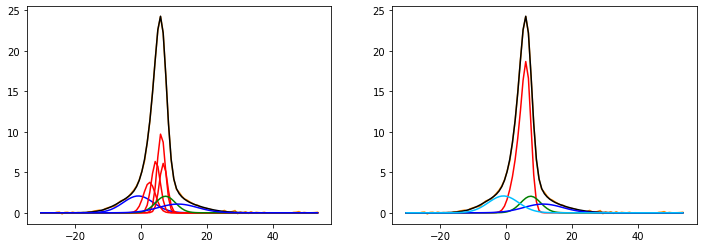

In [75]:
run_num = random.randint(0,150)
print("Run Number:",run_num)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(subvel, LVC_cube_base[:, 175, 36], color='darkorange')
plt.plot(subvel, np.mean(model_mean, 0)[:, 175, 36], color='black')
for i in range(7):
    if gaussian_params_abs[run_num][2::3][i]*dv < 2.3:
        color="red"
    if gaussian_params_abs[run_num][2::3][i]*dv > 2.3 and gaussian_params_abs[run_num][2::3][i]*dv < 5.4:
        color="green"
    if gaussian_params_abs[run_num][2::3][i]*dv > 5.4:
        color="blue"
    plt.plot(subvel, gaussians[run_num][i], color=color)
plt.subplot(1,2,2)
plt.plot(subvel, LVC_cube_base[:, 175, 36], color='darkorange')
plt.plot(subvel, np.mean(model_mean, 0)[:, 175, 36], color='black')
plt.plot(subvel, gaussians_CNM[run_num], color="red")
plt.plot(subvel, gaussians_LNM[run_num], color="green")
plt.plot(subvel, gaussians_WNMa[run_num], color="blue")
plt.plot(subvel, gaussians_WNMb[run_num], color="deepskyblue")

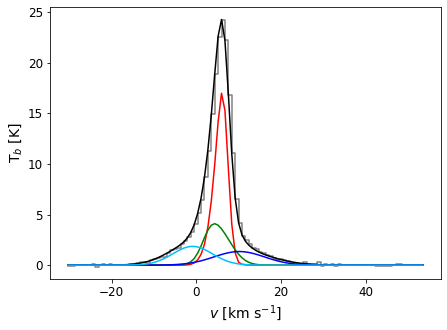

In [76]:
fig = plt.figure(figsize=(7, 5))
import matplotlib
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=14)
plt.ylabel("T$_{b}$ [K]", fontsize=14)
plt.step(subvel, LVC_cube_base[:, 175, 36], color='grey')
plt.plot(subvel, np.mean(model_mean, 0)[:, 175, 36], color='black')
plt.plot(subvel, np.mean(gaussians_CNM, 0), color="red")
plt.plot(subvel, np.mean(gaussians_LNM, 0), color="green")
plt.plot(subvel, np.mean(gaussians_WNMa, 0), color="blue")
plt.plot(subvel, np.mean(gaussians_WNMb, 0), color="deepskyblue")
#fig.savefig("ROHSA_GHIGLS_DF_source_tmp1.png", bbox_inches='tight')

## Sort the Models (150 runs) into PPV cubes of each Phase

In [77]:
CNM_LNM_bound=2.3
LNM_WNM_bound=5.4

In [78]:
def phase_cubes_comp_by_comp(subcube, n_gauss, position, dispersion, amplitude_pix, position_pix,\
                             dispersion_pix, CNM_list, LNM_list, WNMa_list, WNMd_list):

    model_CNM = np.zeros(subcube.shape)
    model_LNM = np.zeros(subcube.shape)
    model_WNM = np.zeros(subcube.shape)

    model_CNM = core.return_result_cube(ampfield=np.array(ampfield)[CNM_list],\
                                        pixfield=np.array(pixfield)[CNM_list], \
                                        sigfield=np.array(sigfield/dv)[CNM_list])
    model_LNM = core.return_result_cube(ampfield=np.array(ampfield)[LNM_list],\
                                        pixfield=np.array(pixfield)[LNM_list], \
                                        sigfield=np.array(sigfield/dv)[LNM_list])
    model_WNMa = core.return_result_cube(ampfield=np.array(ampfield)[WNMa_list],\
                                         pixfield=np.array(pixfield)[WNMa_list], \
                                         sigfield=np.array(sigfield/dv)[WNMa_list])
    model_WNMd = core.return_result_cube(ampfield=np.array(ampfield)[WNMd_list],\
                                         pixfield=np.array(pixfield)[WNMd_list], \
                                         sigfield=np.array(sigfield/dv)[WNMd_list])

    return model_CNM, model_LNM, model_WNMa, model_WNMd

In [79]:
def phase_maps_comp_by_comp(CNM_LNM_bound, LNM_WNM_bound, subcube, n_gauss, position, dispersion, NHI_map):

    iddx = np.argsort(np.mean(position, axis=(1,2))) # Sorts the Gaussians starting from low velocity to high
    mean_position = [np.mean(position, (1,2))[idd] for idd in iddx]
    mean_dispersion = [np.mean(dispersion, (1,2))[idd] for idd in iddx]
    NHI_map_field = [NHI_map[idd] for idd in iddx]

    CNM_map = np.zeros((256,256))#;CNM_list = []
    LNM_map = np.zeros((256,256))#;LNM_list = []
    WNMa_map = np.zeros((256,256))#;WNMa_list = []
    WNMd_map = np.zeros((256,256))#;WNMd_list = []

    for i in range(n_gauss):
        if mean_dispersion[i] < CNM_LNM_bound:
            CNM_map = CNM_map + NHI_map_field[i]
            #CNM_list.append(i)
        if mean_dispersion[i] >= CNM_LNM_bound and mean_dispersion[i] < LNM_WNM_bound:
            LNM_map = LNM_map + NHI_map_field[i]
            #LNM_list.append(i)
        if mean_dispersion[i] >= LNM_WNM_bound:
            if mean_position[i] > 5.:
                WNMa_map = WNMa_map + NHI_map_field[i]
                #WNMa_list.append(i)  
            if mean_position[i] <= 5.:
                WNMd_map = WNMd_map + NHI_map_field[i]
                #WNMd_list.append(i)  
                
    return CNM_map, LNM_map, WNMa_map, WNMd_map #CNM_list, LNM_list, WNMa_list, WNMd_list, 

## Generate the Maps and create the Figure for NH

In [80]:
CNM_maps = np.zeros((150,256,256))
LNM_maps = np.zeros((150,256,256))
WNMa_maps = np.zeros((150,256,256))
WNMd_maps = np.zeros((150,256,256))

# boot cube:
for i in range(50):
    CNM_maps[i],LNM_maps[i],WNMa_maps[i],WNMd_maps[i] = phase_maps_comp_by_comp(CNM_LNM_bound,\
    LNM_WNM_bound, LVC_cube[i], n_gauss, position_multi_rnd_boot_cube[i], dispersion_multi_rnd_boot_cube[i],\
    NHI_map_multi_rnd_boot_cube[i])
    
# lambdas:
for i in range(50):
    CNM_maps[i+50],LNM_maps[i+50],WNMa_maps[i+50],WNMd_maps[i+50] = phase_maps_comp_by_comp(CNM_LNM_bound,\
    LNM_WNM_bound, LVC_cube_base, n_gauss, position_multi_rnd_lambdas[i], dispersion_multi_rnd_lambdas[i],\
    NHI_map_multi_rnd_lambdas[i])
    
# sigma-v selection:
for i in range(50):
    CNM_maps[i+100],LNM_maps[i+100],WNMa_maps[i+100],WNMd_maps[i+100] = phase_maps_comp_by_comp(CNM_LNM_bound,\
    LNM_WNM_bound, LVC_cube_base, n_gauss, position_multi_from_sigma_v[i], dispersion_multi_from_sigma_v[i],\
    NHI_map_multi_from_sigma_v[i])

In [81]:
total_maps = CNM_maps+LNM_maps+WNMa_maps+WNMd_maps
mean_total_map = np.mean(total_maps, 0)

In [82]:
CNM_maps = CNM_maps/1e20
LNM_maps = LNM_maps/1e20
WNMa_maps = WNMa_maps/1e20
WNMd_maps = WNMd_maps/1e20
total_maps = total_maps/1e20

In [83]:
mean_bc_CNM_map = np.mean(np.array(CNM_maps[:50]), 0)
mean_ls_CNM_map = np.mean(CNM_maps[50:100], 0)
mean_sv_CNM_map = np.mean(CNM_maps[100:], 0)

mean_bc_LNM_map = np.mean(np.array(LNM_maps[:50]), 0)
mean_ls_LNM_map = np.mean(LNM_maps[50:100], 0)
mean_sv_LNM_map = np.mean(LNM_maps[100:], 0)

mean_bc_WNMa_map = np.mean(np.array(WNMa_maps[:50]), 0)
mean_ls_WNMa_map = np.mean(WNMa_maps[50:100], 0)
mean_sv_WNMa_map = np.mean(WNMa_maps[100:], 0)

mean_bc_WNMd_map = np.mean(np.array(WNMd_maps[:50]), 0)
mean_ls_WNMd_map = np.mean(WNMd_maps[50:100], 0)
mean_sv_WNMd_map = np.mean(WNMd_maps[100:], 0)

In [84]:
mean_CNM_NH_map = (mean_bc_CNM_map+mean_ls_CNM_map+mean_sv_CNM_map)/3.
mean_LNM_NH_map = (mean_bc_LNM_map+mean_ls_LNM_map+mean_sv_LNM_map)/3.
mean_WNMa_NH_map = (mean_bc_WNMa_map+mean_ls_WNMa_map+mean_sv_WNMa_map)/3.
mean_WNMd_NH_map = (mean_bc_WNMd_map+mean_ls_WNMd_map+mean_sv_WNMd_map)/3.

In [85]:
std_bc_CNM_map = np.std(np.array(CNM_maps[:50]), 0)
std_ls_CNM_map = np.std(CNM_maps[50:100], 0)
std_sv_CNM_map = np.std(CNM_maps[100:], 0)

std_bc_LNM_map = np.std(np.array(LNM_maps[:50]), 0)
std_ls_LNM_map = np.std(LNM_maps[50:100], 0)
std_sv_LNM_map = np.std(LNM_maps[100:], 0)

std_bc_WNMa_map = np.std(np.array(WNMa_maps[:50]), 0)
std_ls_WNMa_map = np.std(WNMa_maps[50:100], 0)
std_sv_WNMa_map = np.std(WNMa_maps[100:], 0)

std_bc_WNMd_map = np.std(np.array(WNMd_maps[:50]), 0)
std_ls_WNMd_map = np.std(WNMd_maps[50:100], 0)
std_sv_WNMd_map = np.std(WNMd_maps[100:], 0)

In [86]:
std_CNM_NH_map = np.sqrt(std_bc_CNM_map**2+std_ls_CNM_map**2+std_sv_CNM_map**2)
std_LNM_NH_map = np.sqrt(std_bc_LNM_map**2+std_ls_LNM_map**2+std_sv_LNM_map**2)
std_WNMa_NH_map = np.sqrt(std_bc_WNMa_map**2+std_ls_WNMa_map**2+std_sv_WNMa_map**2)
std_WNMd_NH_map = np.sqrt(std_bc_WNMd_map**2+std_ls_WNMd_map**2+std_sv_WNMd_map**2)

(-0.5, 255.5, -0.5, 255.5)

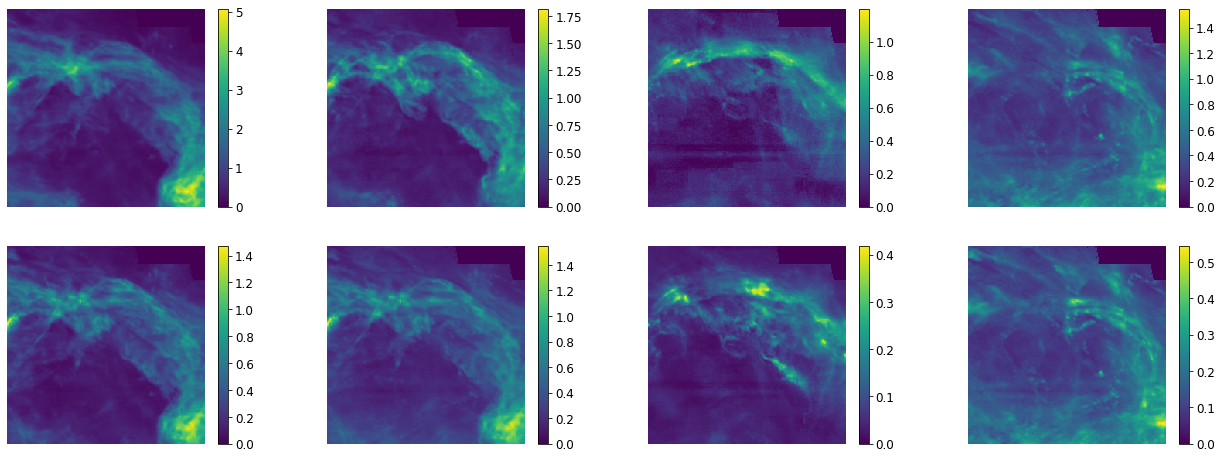

In [87]:
plt.figure(figsize=(22,8))
plt.subplot(2,4,1); plt.imshow(mean_CNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,2); plt.imshow(mean_LNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,3); plt.imshow(mean_WNMa_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,4); plt.imshow(mean_WNMd_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,5); plt.imshow(std_CNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,6); plt.imshow(std_LNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,7); plt.imshow(std_WNMa_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,8); plt.imshow(std_WNMd_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")

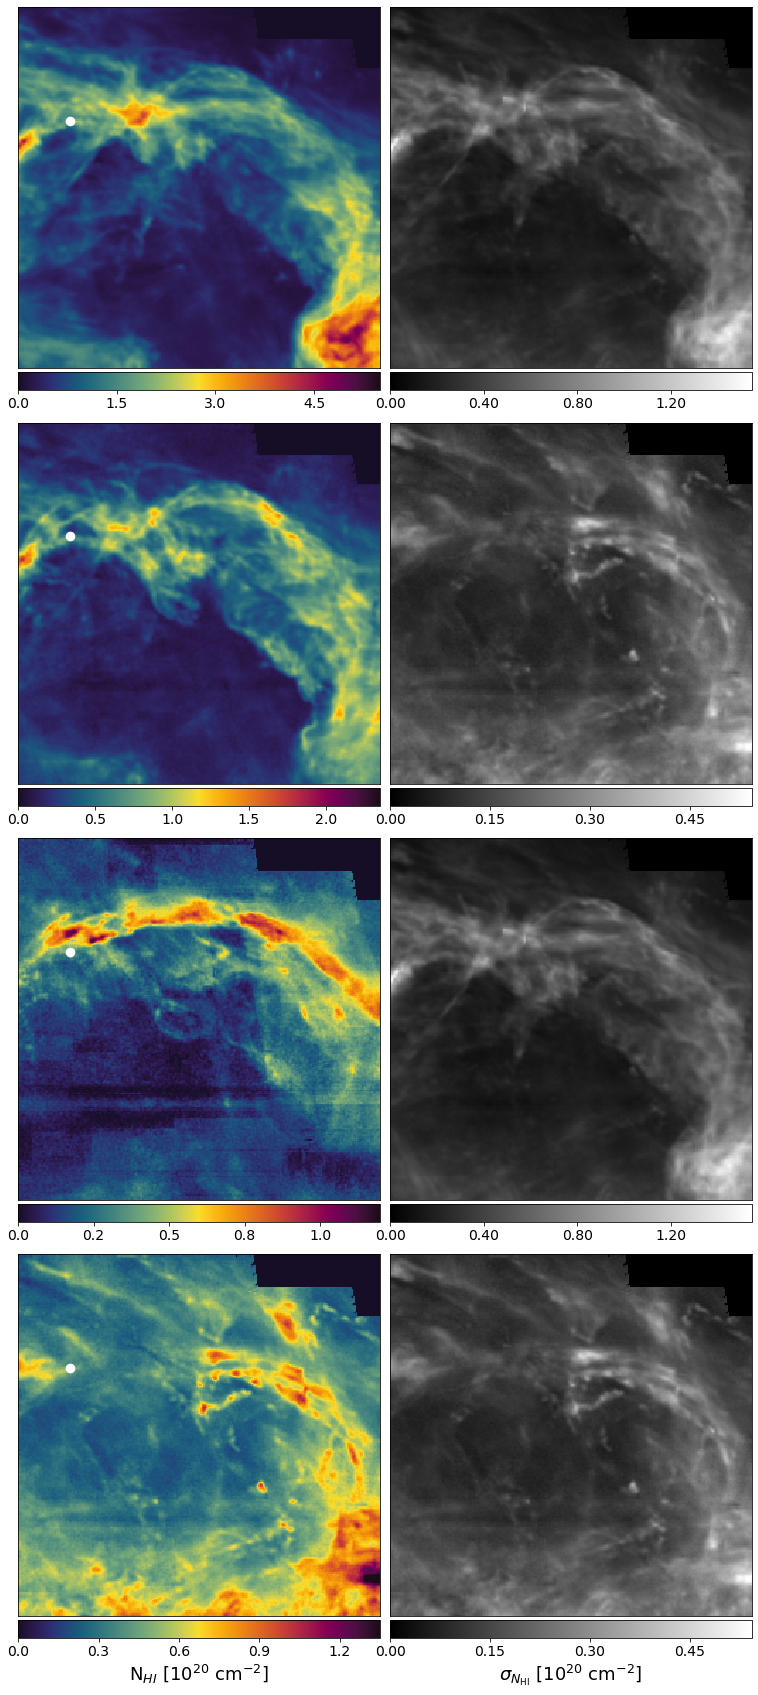

In [88]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()
import cmasher as cmr
cmap_NH = cmr.pride                  
cmap_NH = plt.get_cmap('cmr.pride')

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow(mean_CNM_NH_map, origin='lower', cmap=cmap_NH, vmin=0, vmax=5.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow(std_LNM_NH_map, origin='lower', cmap=reversed_color_map)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
#axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow(mean_LNM_NH_map, origin='lower', cmap=cmap_NH, vmin=0, vmax=2.35)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow(std_WNMd_NH_map, origin='lower', cmap=reversed_color_map)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
#axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow(mean_WNMa_NH_map, origin='lower', cmap=cmap_NH, vmin=0)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow(std_LNM_NH_map, origin='lower', cmap=reversed_color_map)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
#axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow(mean_WNMd_NH_map, origin='lower', cmap=cmap_NH, vmin=0, vmax=1.35)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow(std_WNMd_NH_map, origin='lower', cmap=reversed_color_map)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)
for k in range(4):
    axs[k][0].scatter([36], [175], color='white', s=75)
cbar7.set_label(r"N$_{HI}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
cbar8.set_label(r"$\sigma_{N_{\rm HI}}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
fig.savefig("BEST_NH_maps_phases_with_Sigmas.png", bbox_inches='tight')

## Generate the Maps and create the Figure for Mass Fraction

In [89]:
frac_CNM_maps = CNM_maps/total_maps
frac_LNM_maps = LNM_maps/total_maps
frac_WNMa_maps = WNMa_maps/total_maps
frac_WNMd_maps = WNMd_maps/total_maps

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.



In [90]:
frac_mean_bc_CNM_map = np.mean(np.array(frac_CNM_maps[:50]), 0)
frac_mean_ls_CNM_map = np.mean(frac_CNM_maps[50:100], 0)
frac_mean_sv_CNM_map = np.mean(frac_CNM_maps[100:], 0)

frac_mean_bc_LNM_map = np.mean(np.array(frac_LNM_maps[:50]), 0)
frac_mean_ls_LNM_map = np.mean(frac_LNM_maps[50:100], 0)
frac_mean_sv_LNM_map = np.mean(frac_LNM_maps[100:], 0)

frac_mean_bc_WNMa_map = np.mean(np.array(frac_WNMa_maps[:50]), 0)
frac_mean_ls_WNMa_map = np.mean(frac_WNMa_maps[50:100], 0)
frac_mean_sv_WNMa_map = np.mean(frac_WNMa_maps[100:], 0)

frac_mean_bc_WNMd_map = np.mean(np.array(frac_WNMd_maps[:50]), 0)
frac_mean_ls_WNMd_map = np.mean(frac_WNMd_maps[50:100], 0)
frac_mean_sv_WNMd_map = np.mean(frac_WNMd_maps[100:], 0)

In [91]:
frac_mean_CNM_NH_map = (frac_mean_bc_CNM_map+frac_mean_ls_CNM_map+frac_mean_sv_CNM_map)/3.
frac_mean_LNM_NH_map = (frac_mean_bc_LNM_map+frac_mean_ls_LNM_map+frac_mean_sv_LNM_map)/3.
frac_mean_WNMa_NH_map = (frac_mean_bc_WNMa_map+frac_mean_ls_WNMa_map+frac_mean_sv_WNMa_map)/3.
frac_mean_WNMd_NH_map = (frac_mean_bc_WNMd_map+frac_mean_ls_WNMd_map+frac_mean_sv_WNMd_map)/3.

In [92]:
frac_std_bc_CNM_map = np.std(np.array(frac_CNM_maps[:50]), 0)
frac_std_ls_CNM_map = np.std(frac_CNM_maps[50:100], 0)
frac_std_sv_CNM_map = np.std(frac_CNM_maps[100:], 0)

frac_std_bc_LNM_map = np.std(np.array(frac_LNM_maps[:50]), 0)
frac_std_ls_LNM_map = np.std(frac_LNM_maps[50:100], 0)
frac_std_sv_LNM_map = np.std(frac_LNM_maps[100:], 0)

frac_std_bc_WNMa_map = np.std(np.array(frac_WNMa_maps[:50]), 0)
frac_std_ls_WNMa_map = np.std(frac_WNMa_maps[50:100], 0)
frac_std_sv_WNMa_map = np.std(frac_WNMa_maps[100:], 0)

frac_std_bc_WNMd_map = np.std(np.array(frac_WNMd_maps[:50]), 0)
frac_std_ls_WNMd_map = np.std(frac_WNMd_maps[50:100], 0)
frac_std_sv_WNMd_map = np.std(frac_WNMd_maps[100:], 0)

In [93]:
frac_std_CNM_NH_map = np.sqrt(frac_std_bc_CNM_map**2+frac_std_ls_CNM_map**2+frac_std_sv_CNM_map**2)
frac_std_LNM_NH_map = np.sqrt(frac_std_bc_LNM_map**2+frac_std_ls_LNM_map**2+frac_std_sv_LNM_map**2)
frac_std_WNMa_NH_map = np.sqrt(frac_std_bc_WNMa_map**2+frac_std_ls_WNMa_map**2+frac_std_sv_WNMa_map**2)
frac_std_WNMd_NH_map = np.sqrt(frac_std_bc_WNMd_map**2+frac_std_ls_WNMd_map**2+frac_std_sv_WNMd_map**2)

(-0.5, 255.5, -0.5, 255.5)

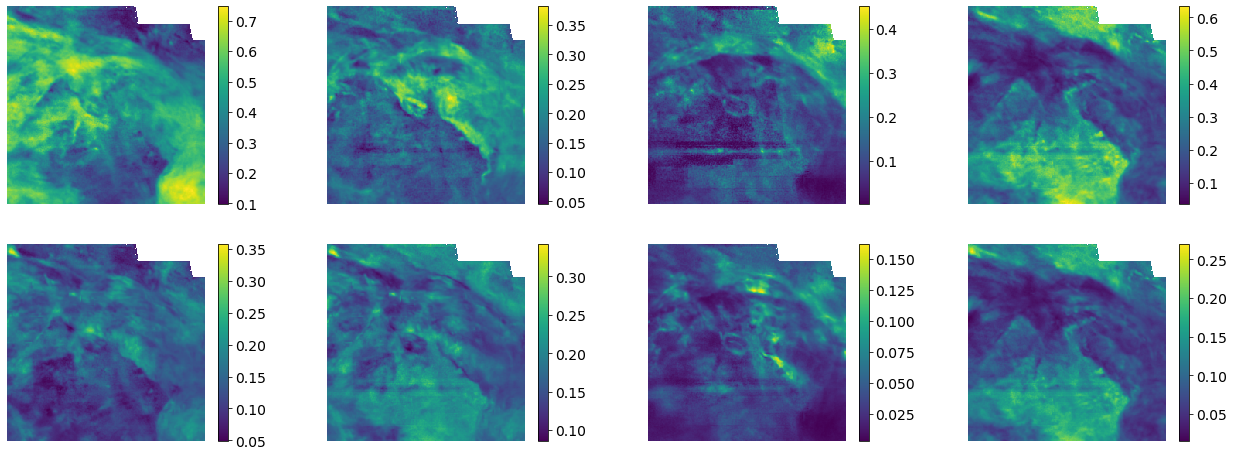

In [94]:
plt.figure(figsize=(22,8))
plt.subplot(2,4,1); plt.imshow(frac_mean_CNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,2); plt.imshow(frac_mean_LNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,3); plt.imshow(frac_mean_WNMa_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,4); plt.imshow(frac_mean_WNMd_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,5); plt.imshow(frac_std_CNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,6); plt.imshow(frac_std_LNM_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,7); plt.imshow(frac_std_WNMa_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(2,4,8); plt.imshow(frac_std_WNMd_NH_map, origin='lower'); plt.colorbar(); plt.axis("off")

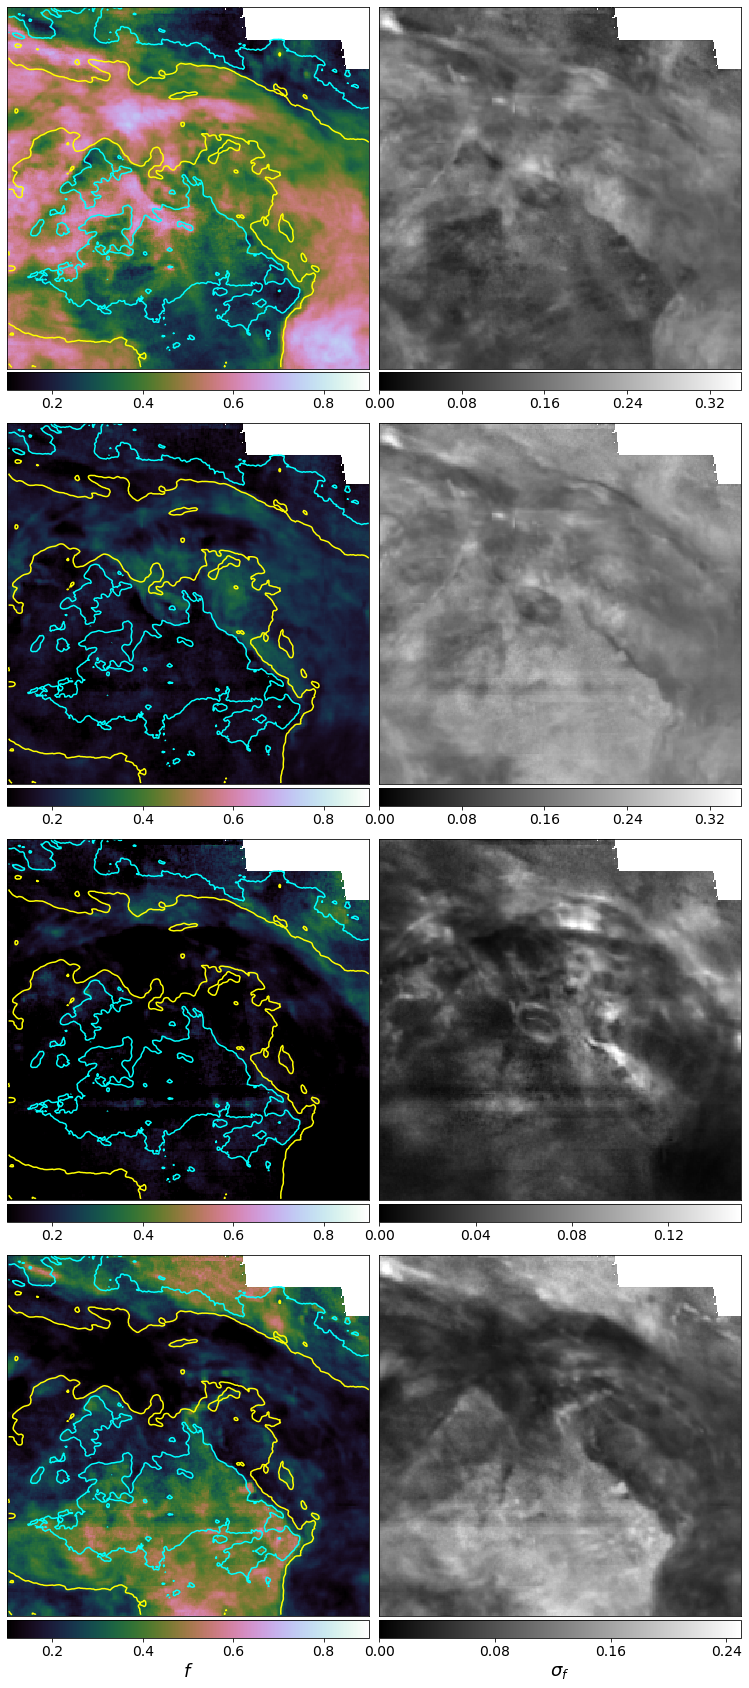

In [95]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
cmap_MF = "cubehelix"
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow(frac_mean_CNM_NH_map, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8999 )
cont_col_dens_mf_CNM=axs[0][0].contour(mean_total_map, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow(frac_std_CNM_NH_map, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.35)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow(frac_mean_LNM_NH_map, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8999 )
cont_col_dens_mf_LNM=axs[1][0].contour(mean_total_map, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow(frac_std_LNM_NH_map, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.35)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow(frac_mean_WNMa_NH_map, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8999 )
cont_col_dens_mf_WNM=axs[2][0].contour(mean_total_map, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow(frac_std_WNMa_NH_map, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.15)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow(frac_mean_WNMd_NH_map, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8999 )
cont_col_dens_mf_WNM=axs[3][0].contour(mean_total_map, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow(frac_std_WNMd_NH_map, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.25)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)

cbar7.set_label(r"$f$", fontsize=18.)
cbar8.set_label(r"$\sigma_{f}$", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
fig.savefig("BEST_frac_NH_maps_phases_with_Sigmas.png", bbox_inches='tight')

In [96]:
empty_primary = fits.PrimaryHDU(mean_CNM_NH_map, header=hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("best_CNM_NH_map_NEW.fits", clobber=True)

______________________________________________________________________